In [76]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import csv
import pandas as pd

Lets start with defining a function that can read any of the CSV files into a numpy array.

In [77]:
def csv_to_np(csv):
    return pd.read_csv(csv, header=0).to_numpy()


test_csv_to_np = csv_to_np('Desktop/HW4data/a/2/Test_2a.csv')
print(test_csv_to_np.shape)
test_csv_to_np = csv_to_np('Desktop/HW4data/a/2/Train_2a.csv')
print(test_csv_to_np.shape)

(15, 13)
(170, 14)


Now that we have a function that can turn the csv files into numpy arrays, we can create a training and test dataset in a more convenient format. I chose to put my datasets into python dictionaries.

In [109]:
train_ds = {}

for i in range(1,6):
    train_ds['{}a'.format(i)] = csv_to_np('Desktop/HW4data/a/{}/Train_{}a.csv'.format(i,i))
for i in range(1,6):
    train_ds['{}b'.format(i)] = csv_to_np('Desktop/HW4data/b/{}/TrainX_{}b.csv'.format(i,i))

test_ds = {}

for i in range(1,6):
    test_ds['{}a'.format(i)] = csv_to_np('Desktop/HW4data/a/{}/Test_{}a.csv'.format(i,i))
for i in range(1,6):
    test_ds['{}b'.format(i)] = csv_to_np('Desktop/HW4data/b/{}/Test_{}b.csv'.format(i,i))



Now that we have the datasets in a more convenient format, we can now clean up any outliers in the data. In order to do that, we can use PCA to reduce the dimensionality of the data so that we may more easily spot outliers. In order to see how much we can reduce the dimensionality of the data without destroying too much of the variance, we should plot the variance retained over the principal components for each of the training datasets.

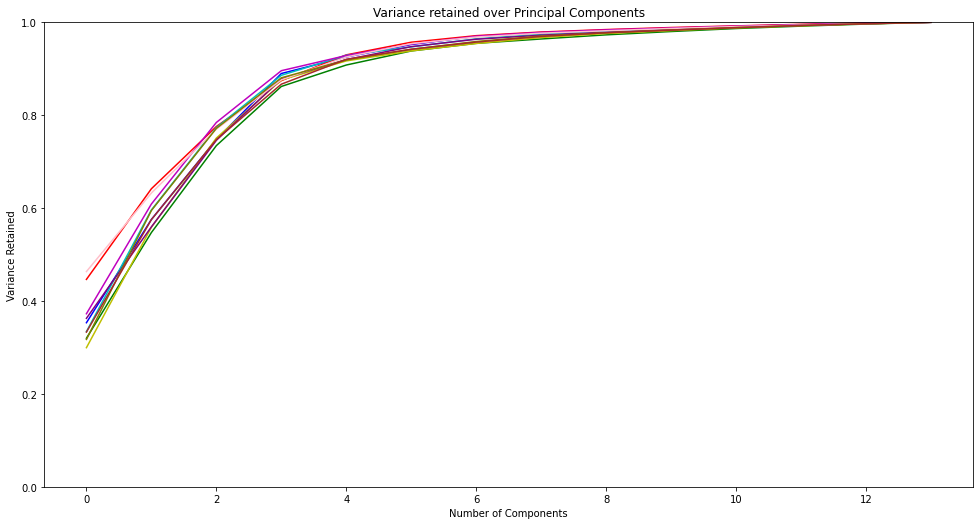

In [79]:
fig = plt.figure(figsize = (40,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
ax = fig.add_subplot(3,3,i+1)

colors = ['b','g','r','y','c','m','purple','pink','olive','brown']
for i, table in enumerate(train_ds):
    pca_digits = PCA(14).fit(train_ds[table])
    ax.plot(np.cumsum(pca_digits.explained_variance_ratio_), c=colors[i])
plt.xlabel("Number of Components")
plt.ylabel("Variance Retained")
plt.ylim(0,1)
plt.title('Variance retained over Principal Components')
plt.show()

It looks like for each of the training datasets, most of the variance is retained in the first three principal components. Now, lets plot one of the training datasets over its first three and two principal components to see what it looks like. 

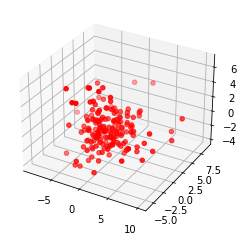

In [135]:
def plot_reduced_data(data):
    reduc_data = PCA(3).fit_transform(data)
    ax = plt.figure().add_subplot(111,projection='3d').scatter(reduc_data[:,0],
                                                          reduc_data[:,1],
                                                          reduc_data[:,2],
                                                          c='red')
    plt.show()
    
def plot_reduced_data_2d(data):
    reduc_data = PCA(2).fit_transform(data)
    plt.scatter(reduc_data[:,0], reduc_data[:,1], c='red')
    plt.show()
    
    
plot_reduced_data(train_ds['1a'])

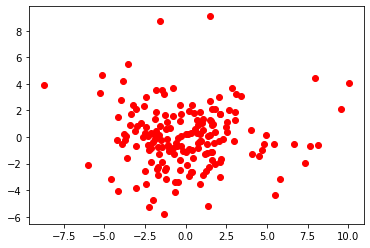

In [136]:
plot_reduced_data_2d(train_ds['1a'])

Now we can define a function that will perform linear regression on our data.

In [137]:
def lin_reg(X, y):
    return np.linalg.inv(X.T @ X) @ (X.T @ y)


X = train_ds['1a'][:,:-1]
y = train_ds['1a'][:,-1]
print("Shape of inputs is: " + str(X.shape))
print("Shape of outputs is: " + str(y.shape))
w = lin_reg(X,y)
pd.DataFrame(w)

Shape of inputs is: (177, 13)
Shape of outputs is: (177,)


,0
0,-0.109067
1,0.007981
2,-0.075958
3,0.059832
4,0.056045
5,0.020508
6,0.113667
7,0.064097
8,-0.021726
9,-0.090377


We should define a function that calculates the error of our linear regression model.

In [97]:
def calc_error(X, y, w):
    return ((y - (X @ w)).T @ (y - (X @ w)))


err = calc_error(X, y, w)
print(round(err,2))

15.08


We can now begin to clean the data of outliers. Let us define a function that highlights the indeces of the data points in the reduced data set that are causing the most error for out model so that we may remove them from the actual dataset. We are going to assume an outlier frequency of 7%, so that would translate to 12 data points that will be considered outliers.

In [98]:
def outlier_inds(ds, PCs):
    lst = []
    reduc_ds = PCA(PCs).fit_transform(ds)
    ideal_len = round(len(ds) - (len(ds)*0.07))
    while(len(reduc_ds) > ideal_len):
        X = reduc_ds[:,:-1]
        y = reduc_ds[:,-1]
        w = lin_reg(X, y)
        min_err = calc_error(X, y, w)
        greatest_outlier = 0
        for i in range(len(reduc_ds)):
            X = np.delete(reduc_ds[:,:-1], [i], axis=0)
            y = np.delete(reduc_ds[:,-1], [i], axis=0)
            w = lin_reg(X, y)
            err = calc_error(X, y, w)
            if  err < min_err:
                min_err = err
                greatest_outlier = i
        lst.append(greatest_outlier)
        reduc_ds = np.delete(reduc_ds, greatest_outlier, axis=0)
        X = reduc_ds[:,:-1]
        y = reduc_ds[:,-1]
        w = lin_reg(X, y)
    return lst
        

print(outlier_inds(train_ds['1a'], 3))

[84, 78, 110, 71, 98, 4, 108, 58, 124, 6, 77, 10]


Here we have our 12 indeces that hold the data points that cause the greatest error in our model. All we have to do now in order to clean our training dataset is create a method that removes the data points at these indeces. We have to keep in mind that the data points at these indeces must be removed in order because of the way that they are generated. In other words, the data point at index 84 must be removed from the data set, and then the data point at index 78 of the new data set must be removed, and so on.

In [99]:
def remove_outliers(ds, PCs):
    inds = outlier_inds(ds, PCs)
    for ind in inds:
        ds = np.delete(ds, ind, axis=0)
    return ds


Now we can test to see how well this method worked for cleaning our data:

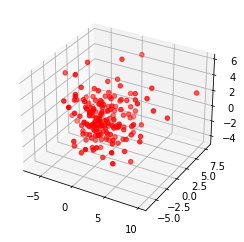

Error is: 757.51


In [102]:
test_ds = train_ds['4a']

plot_reduced_data(test_ds)

test_ds_reduced = PCA(3).fit_transform(test_ds)

X = test_ds_reduced[:,:-1]
y = test_ds_reduced[:,-1]
w = lin_reg(X, y)

print('Error is: ' + str(round(calc_error(X, y, w),2)))

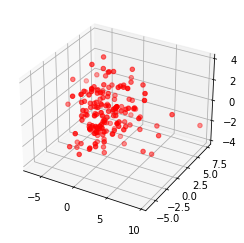

Error is: 498.76


In [103]:
clean_test_ds = remove_outliers(test_ds, 3)

plot_reduced_data(clean_test_ds)

clean_test_ds_reduced = PCA(3).fit_transform(clean_test_ds)

X = clean_test_ds_reduced[:,:-1]
y = clean_test_ds_reduced[:,-1]
w = lin_reg(X, y)

print('Error is: ' + str(round(calc_error(X, y, w),2)))

We can see that this method worked well for cleaning our data. The error of our linear regression model for the reduced data was much lower once the outliers were removed. We can now clean the data.

In [104]:
def clean_ds(ds):
    clean_ds = {}
    for key in ds:
        clean_ds[key] = remove_outliers(ds[key],3)
    return clean_ds

train_ds = clean_ds(train_ds)

Now, we are ready to start testing different models for our data. I chose to begin with the simple linear regression model that I defined earlier to train on the training datasets. I chose to use a 85/15 split when partitioning the training data into a training set and a validation set, and each dataset is shuffled prior to the partition.

In [105]:
def train_lnrg_models(data):
    errors = np.zeros((len(data)))
    models = {}
    error_str = ""
    for i,key in enumerate(data):
        ds = data[key]
        np.random.shuffle(ds)
        split_ind = round(len(ds)*0.85)
        train_X = ds[:split_ind,:-1]
        train_y = ds[:split_ind,-1]
        val_X = ds[split_ind:,:-1]
        val_y = ds[split_ind:,-1]
        w = lin_reg(train_X, train_y)
        models[key] = w
        errors[i] = round(calc_error(val_X, val_y, w), 2)
        error_str += "Error of model for dataset " + key + ": " + str(errors[i]) + "\n"
    error_str += "\nAverage error of these models: " + str(round(np.mean(errors),2))
    return models, error_str


In [106]:
models, error_summary = train_lnrg_models(train_ds)
print(error_summary)

Error of model for dataset 1a: 3.74
Error of model for dataset 2a: 5.19
Error of model for dataset 3a: 2.22
Error of model for dataset 4a: 3.58
Error of model for dataset 5a: 1.79
Error of model for dataset 1b: 0.82
Error of model for dataset 2b: 2.97
Error of model for dataset 3b: 2.53
Error of model for dataset 4b: 2.28
Error of model for dataset 5b: 4.9

Average error of these models: 3.0


A simple linear regression model seemed to work fairly well with a relatively low and consistent error rate across the different training datasets. Lets define a function that can print the predictions for the test datasets.

In [107]:
def predict(ds, models):
    predictions = {}
    for key in ds:
        test = ds[key]
        model = models[key]
        predictions[key] = test @ model
    return predictions

In [138]:
df = pd.DataFrame.from_dict(predict(test_ds, models))
df

,1a,2a,3a,4a,5a,1b,2b,3b,4b,5b
0,0.130868,-0.067622,-0.038081,-0.111593,-0.071907,0.110830,0.120017,-0.415551,-0.010932,-0.149994
1,0.537021,-0.133510,-0.142262,-0.105567,-0.003911,0.123688,0.028070,-0.268120,-0.036402,-0.166026
2,0.242940,0.213385,0.119924,0.006695,0.072006,0.092664,0.054096,-0.052984,0.005676,-0.025743
3,0.245470,0.262380,-0.024289,-0.323621,0.116432,0.026475,0.399991,-0.157973,-0.076400,-0.014003
4,0.261843,0.348383,-0.236350,-0.362672,-0.084656,0.127978,0.102291,-0.109914,-0.201065,-0.031622
5,0.405447,-0.012959,-0.053217,-0.259137,-0.178392,0.189682,0.171904,-0.315839,-0.248629,0.045159
6,0.451045,0.085395,-0.133391,-0.148225,-0.148610,0.303742,0.087789,-0.314770,-0.114502,-0.101743
7,0.401510,0.318886,0.024065,-0.341950,-0.021365,0.093410,-0.185977,-0.429319,-0.014242,-0.085107
8,0.113391,-0.101684,-0.050889,0.046438,-0.020927,0.078433,-0.193190,-0.108886,-0.123063,0.253172
9,0.291670,-0.002429,0.051437,-0.152079,-0.002570,0.069837,0.187613,-0.119832,-0.144720,-0.062886


Although the linear regression model may be adequate, we may be able to get better results if we reduced the effect of unimportant features on our model. One way that we could do this is with a technique called Lasso.

.

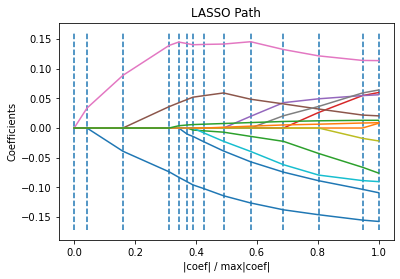

In [270]:
from sklearn import linear_model

X = train_ds['1a'][:,:-1]
y = train_ds['1a'][:,-1]

_,_, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()

plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

It looks like a good value for alpha could be 0.01. Let's use the value 0.01 for alpha in our Lasso model and compare the results of that model to our standard linear regression model.

In [261]:
def lasso_ds(ds, alpha, val_split):
    split_ind = round(len(ds)*val_split)
    lasso = linear_model.Lasso(alpha=alpha)
    np.random.shuffle(ds)
    train_X = ds[:split_ind,:-1]
    train_y = ds[:split_ind,-1]
    test_X = ds[split_ind:,:-1]
    test_y = ds[split_ind:,-1]
    lasso.fit(train_X, train_y)
    return lasso.coef_, calc_error(test_X, test_y, lasso.coef_)


model_test, err_test = lasso_ds(train_ds['1a'], 0.01, 0.85)

print(model_test)
print(err_test)

[-0.03100045  0.         -0.02054219  0.          0.          0.06884128
  0.12359038  0.         -0.         -0.02421968 -0.13470619  0.00242782
 -0.0004183 ]
1.628919109776486


In [264]:
def lasso(data, val_split):
    models = {}
    err_str = ""
    err_sum = 0
    for key in data:
        model, err = lasso_ds(data[key], 0.01, val_split)
        models[key] = model
        err_str += 'Error of model for dataset {}: '.format(key) + str(round(err,2)) + '\n'
        err_sum += err
    err_str += '\nAverage error for these models: ' + str(round((err_sum/len(data)),2))
    return models, err_str
        
models_lasso, error_summary_lasso = lasso(train_ds, 0.85)

print(error_summary_lasso)

Error of model for dataset 1a: 1.49
Error of model for dataset 2a: 3.68
Error of model for dataset 3a: 1.62
Error of model for dataset 4a: 4.63
Error of model for dataset 5a: 0.83
Error of model for dataset 1b: 0.8
Error of model for dataset 2b: 2.73
Error of model for dataset 3b: 3.41
Error of model for dataset 4b: 2.33
Error of model for dataset 5b: 3.18

Average error for these models: 2.47


It looks like the Lasso model makes better predictions on the data than the standard linear regresion model. Lets train the lasso model on the entire training dataset with no validation split, and use that model to make our  predictions on the test dataset.

In [265]:
models_lasso_full,_ = lasso(train_ds, 1)

df_lasso = pd.DataFrame.from_dict(predict(test_ds, models_lasso_full))
df_lasso

,1a,2a,3a,4a,5a,1b,2b,3b,4b,5b
0,-0.093758,0.110011,0.023312,0.045989,-0.027954,-0.054737,-0.049698,-0.202051,-0.096335,-0.146821
1,0.311628,0.021982,-0.116063,-0.060043,-0.012421,0.011907,-0.113506,-0.269914,-0.006353,-0.111360
2,0.047056,0.150689,0.097876,0.013029,0.002839,-0.046333,0.051824,-0.206488,-0.047537,-0.028563
3,0.044683,0.148025,-0.042905,-0.258283,-0.023783,-0.057182,0.271752,-0.176118,-0.076604,-0.070282
4,0.122699,0.186401,-0.178125,-0.228165,-0.072294,0.097917,0.102722,-0.044401,-0.151795,-0.041315
5,0.240717,0.043088,-0.055462,-0.158206,-0.071407,0.100519,0.135024,-0.148502,-0.197484,-0.061779
6,0.219816,0.180679,-0.059188,-0.037723,-0.041299,0.107455,0.123755,-0.169903,-0.075329,-0.068300
7,0.206520,0.195389,0.023532,-0.182848,-0.031327,-0.065396,-0.059841,-0.299536,-0.115818,-0.145598
8,0.151761,-0.037876,-0.017319,0.056368,-0.013809,-0.068193,-0.173837,-0.161241,-0.113650,-0.035197
9,0.089331,-0.024852,0.055649,-0.088939,-0.021521,-0.015854,0.147338,-0.118548,-0.143751,-0.118185


In [268]:
df_lasso.to_csv('Desktop/HW4data/hw4_result.csv', index=index_labels)